In [1]:
import pickle
import numpy as np
from pathlib import Path

from src.input import Input_uc, Input_ed, Input_ed_prev
from src.output import Output_uc, Output_ed, Output_ed_prev, Output_uc_snapshot
from src.unit_commitment import solve_uc, solve_uc_snapshot
from src.economic_dispatch import solve_ed, solve_ed_prev

In [2]:
num_units=122
num_periods=24
num_buses=197

In [3]:
path_folder_processed_kpg193 = Path.cwd().resolve() / "data" / "input" / "processed" / "KPG193_ver1_2"
timestamp_2022 = np.load(Path.cwd().resolve() / "data" / "input" / "processed" / "timestamp_2022.npy")
time_start, time_end = np.datetime64("2022-07-02T00"), np.datetime64("2022-07-02T23")
idx_time_start, idx_time_end = np.where(timestamp_2022 == time_start)[0][0], np.where(timestamp_2022 == time_end)[0][0]

In [4]:
unit_type = np.load(path_folder_processed_kpg193 / "unit_type.npy")

In [5]:
solar_p_max = np.load(path_folder_processed_kpg193 / "solar_p_max_2022.npy")[idx_time_start-1:idx_time_end+1].sum(axis=1)
solar_p_min = np.zeros(num_periods + 1)
wind_p = np.load(path_folder_processed_kpg193 / "wind_p_2022.npy")[idx_time_start-1:idx_time_end+1].sum(axis=1)
hydro_p = np.load(path_folder_processed_kpg193 / "hydro_p_2022.npy")[idx_time_start-1:idx_time_end+1].sum(axis=1)

load = np.load(path_folder_processed_kpg193 / "demand_2022.npy")[idx_time_start-1:idx_time_end+1]
system_reserve_up = np.zeros(num_periods + 1)
system_reserve_down = np.zeros(num_periods + 1)

p_min =  np.load(path_folder_processed_kpg193 / "p_min.npy")
p_max =  np.load(path_folder_processed_kpg193 / "p_max.npy")
ramp_up =  np.load(path_folder_processed_kpg193 / "ramp_up.npy")
ramp_down =  np.load(path_folder_processed_kpg193 / "ramp_down.npy")
startup_ramp =  np.load(path_folder_processed_kpg193 / "startup_ramp.npy")
shutdown_ramp =  np.load(path_folder_processed_kpg193 / "shutdown_ramp.npy")
min_up =  np.load(path_folder_processed_kpg193 / "min_up.npy")
min_down =  np.load(path_folder_processed_kpg193 / "min_down.npy")
cost_quad =  np.load(path_folder_processed_kpg193 / "cost_quad.npy")
cost_lin =  np.load(path_folder_processed_kpg193 / "cost_lin.npy")
cost_const =  np.load(path_folder_processed_kpg193 / "cost_const.npy")

In [6]:
cost_startup_step = pickle.load(open(path_folder_processed_kpg193 / "cost_startup_step.pkl", "rb"))
num_cooling_steps = np.array([len(csc_i) for csc_i in cost_startup_step])

u_prev = [
    np.load(path_folder_processed_kpg193 / "status_2022.npy")
    [idx_time_start-num_cooling_steps.max():idx_time_start]
    [:, idx_unit][-lookup:].tolist()
    for idx_unit, lookup in enumerate(num_cooling_steps)
]

In [7]:
mustoff_2022 = np.load(path_folder_processed_kpg193 / "mustoff_2022.npy")
mustoff_2022 = mustoff_2022[
    (mustoff_2022[:, 2] >= idx_time_start) & (mustoff_2022[:, 1] <= idx_time_end)
]
mustoff = []
for unit, start, end in mustoff_2022.tolist():
    start_clipped = max(start, idx_time_start)
    end_clipped = min(end, idx_time_end)
    for t in range(start_clipped, end_clipped + 1):
        mustoff.append((unit, t - int(idx_time_start)))

In [8]:
# p_prev = solve_ed_prev(
#     input_ed_prev=Input_ed_prev(
#         # meta
#         num_units=num_units,
#         num_buses=num_buses,
#         voll=3500*1300,
#         let_blackout=False,
#         curtail_penalty=0,
#         let_curtail=False,
#         exact_reserve=False,
#         # renewable
#         solar_p_max=solar_p_max[0],
#         solar_p_min=solar_p_min[0],
#         wind_p=wind_p[0],
#         hydro_p=hydro_p[0],
#         # system
#         load=load[0],
#         system_reserve_up=system_reserve_up[0],
#         system_reserve_down=system_reserve_down[0],
#         # u_prev
#         u_prev=[u[-1] for u in u_prev],
#         # operational
#         p_min=p_min, p_max=p_max, cost_quad=cost_quad, cost_lin=cost_lin, cost_const=cost_const,
#     ), 
#     output_ed_prev=Output_ed_prev(), 
#     only_p_prev=True,
# )

In [9]:
input_ed_prev=Input_ed_prev(
    # meta
    num_units=num_units,
    num_buses=num_buses,
    voll=3500*1300,
    let_blackout=False,
    curtail_penalty=0,
    let_curtail=False,
    exact_reserve=False,
    # renewable
    solar_p_max=solar_p_max[0],
    solar_p_min=solar_p_min[0],
    wind_p=wind_p[0],
    hydro_p=hydro_p[0],
    # system
    load=load[0],
    system_reserve_up=system_reserve_up[0],
    system_reserve_down=system_reserve_down[0],
    # u_prev
    u_prev=[u[-1] for u in u_prev],
    # operational
    p_min=p_min, p_max=p_max, cost_quad=cost_quad, cost_lin=cost_lin, cost_const=cost_const,
)
output_ed_prev = Output_ed_prev()
solve_ed_prev(input_ed_prev=input_ed_prev, output_ed_prev=output_ed_prev, only_p_prev=False)
p_prev = output_ed_prev.p

Set parameter Username
Set parameter LicenseID to value 2659802
Academic license - for non-commercial use only - expires 2026-05-01


In [10]:
solar_p_max = solar_p_max[1:]
solar_p_min = solar_p_min[1:]
wind_p = wind_p[1:]
hydro_p = hydro_p[1:]
load = load[1:]
system_reserve_up = system_reserve_up[1:]
system_reserve_down = system_reserve_down[1:]

---
---
---

QUSTION 1

UC-ED

In [11]:
input_uc = Input_uc(
    # meta
    num_units=num_units,
    num_periods=num_periods,
    num_buses=num_buses,
    voll=3500*1300,
    let_blackout=False,
    curtail_penalty=0,
    let_curtail=False,
    exact_reserve=False,
    # renewable
    solar_p_max=solar_p_max,
    solar_p_min=solar_p_min,
    wind_p=wind_p,
    hydro_p=hydro_p,
    # system
    load=load,
    system_reserve_up=system_reserve_up,
    system_reserve_down=system_reserve_down,
    # operational constraint
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    # generation cost function
    cost_quad=cost_quad,
    cost_lin=cost_lin,
    cost_const=cost_const,
    # previous horizon
    p_prev=p_prev,
    u_prev=u_prev,
    # startup cost function
    cost_startup_step=cost_startup_step,
    # mustoff
    mustoff=mustoff,
)

In [12]:
output_uc = Output_uc()
solve_uc(input_uc=input_uc, output_uc=output_uc)

something wrong


In [13]:
output_ed = Output_ed(num_periods=num_periods, num_units=num_units, num_buses=num_buses)

for time_period in range(num_periods):
    input_ed = Input_ed(
        # meta
        time_period=time_period,
        num_units=num_units,
        num_buses=num_buses,
        voll=3500*1300,
        let_blackout=False,
        curtail_penalty=0,
        let_curtail=False,
        exact_reserve=False,
        # renewable
        solar_p_max=solar_p_max,
        solar_p_min=solar_p_min,
        # uc
        input_uc=input_uc,
        output_uc=output_uc,
    )

    solve_ed(input_ed=input_ed, output_ed=output_ed)

output_ed.compute_auxiliary_results()
output_uc.compute_auxiliary_results(output_ed=output_ed)

In [14]:
asdf

NameError: name 'asdf' is not defined

ED only (p_min zeroed for all i , all units online)

In [15]:
output_ed_onlyq1 = Output_ed(num_periods=num_periods, num_units=num_units, num_buses=num_buses)

for time_period in range(num_periods):
    input_ed_onlyq1 = Input_ed(
        # meta
        time_period=time_period,
        num_units=num_units,
        num_buses=num_buses,
        voll=3500*1300,
        let_blackout=False,
        curtail_penalty=0,
        let_curtail=False,
        exact_reserve=False,
        # renewable
        solar_p_max=solar_p_max,
        solar_p_min=solar_p_min,
        # uc
        input_uc=input_uc,
        output_uc=output_uc,
    )
    # 
    input_ed_onlyq1.u_uc = [1] * num_units
    input_ed_onlyq1.p_min = [0] * num_units

    solve_ed(input_ed=input_ed_onlyq1, output_ed=output_ed_onlyq1, isitquestion1=True)

output_ed_onlyq1.compute_auxiliary_results()

In [22]:
# Initialize the `u` array to track the unit status (online/offline)
output_ed_onlyq1.u = np.ones((num_units, num_periods))  # Initially, all units are online

# Initialize the no-load cost contribution
output_ed_onlyq1.cost_noload = np.zeros(num_periods)  # Will track the total no-load cost per period

for time_period in range(num_periods):
    # Get generation values for this time period (p[i, t])
    p_values = output_ed_onlyq1.p[:, time_period]
    
    # Initialize the no-load cost for this time period
    no_load_cost = 0

    for i in range(num_units):
        if p_values[i] == 0:  # If the unit is offline (not generating power)
            output_ed_onlyq1.u[i, time_period] = 0  # Mark the unit as offline (u[i] = 0)
        else:  # If the unit is generating power
            # Calculate the no-load cost (added only when generating power)
            no_load_cost += cost_const[i]
            output_ed_onlyq1.u[i, time_period] = 1  # Mark the unit as online (u[i] = 1)
    
    # Add the no-load cost for this time period to the cost generation and system
    output_ed_onlyq1.cost_generation[time_period] += no_load_cost
    output_ed_onlyq1.cost_system[time_period] += no_load_cost

# After updating the costs, compute the auxiliary results (e.g., total costs, etc.)
output_ed_onlyq1.compute_auxiliary_results()


In [41]:
np.array(input_ed_onlyq1.load).shape

(197,)

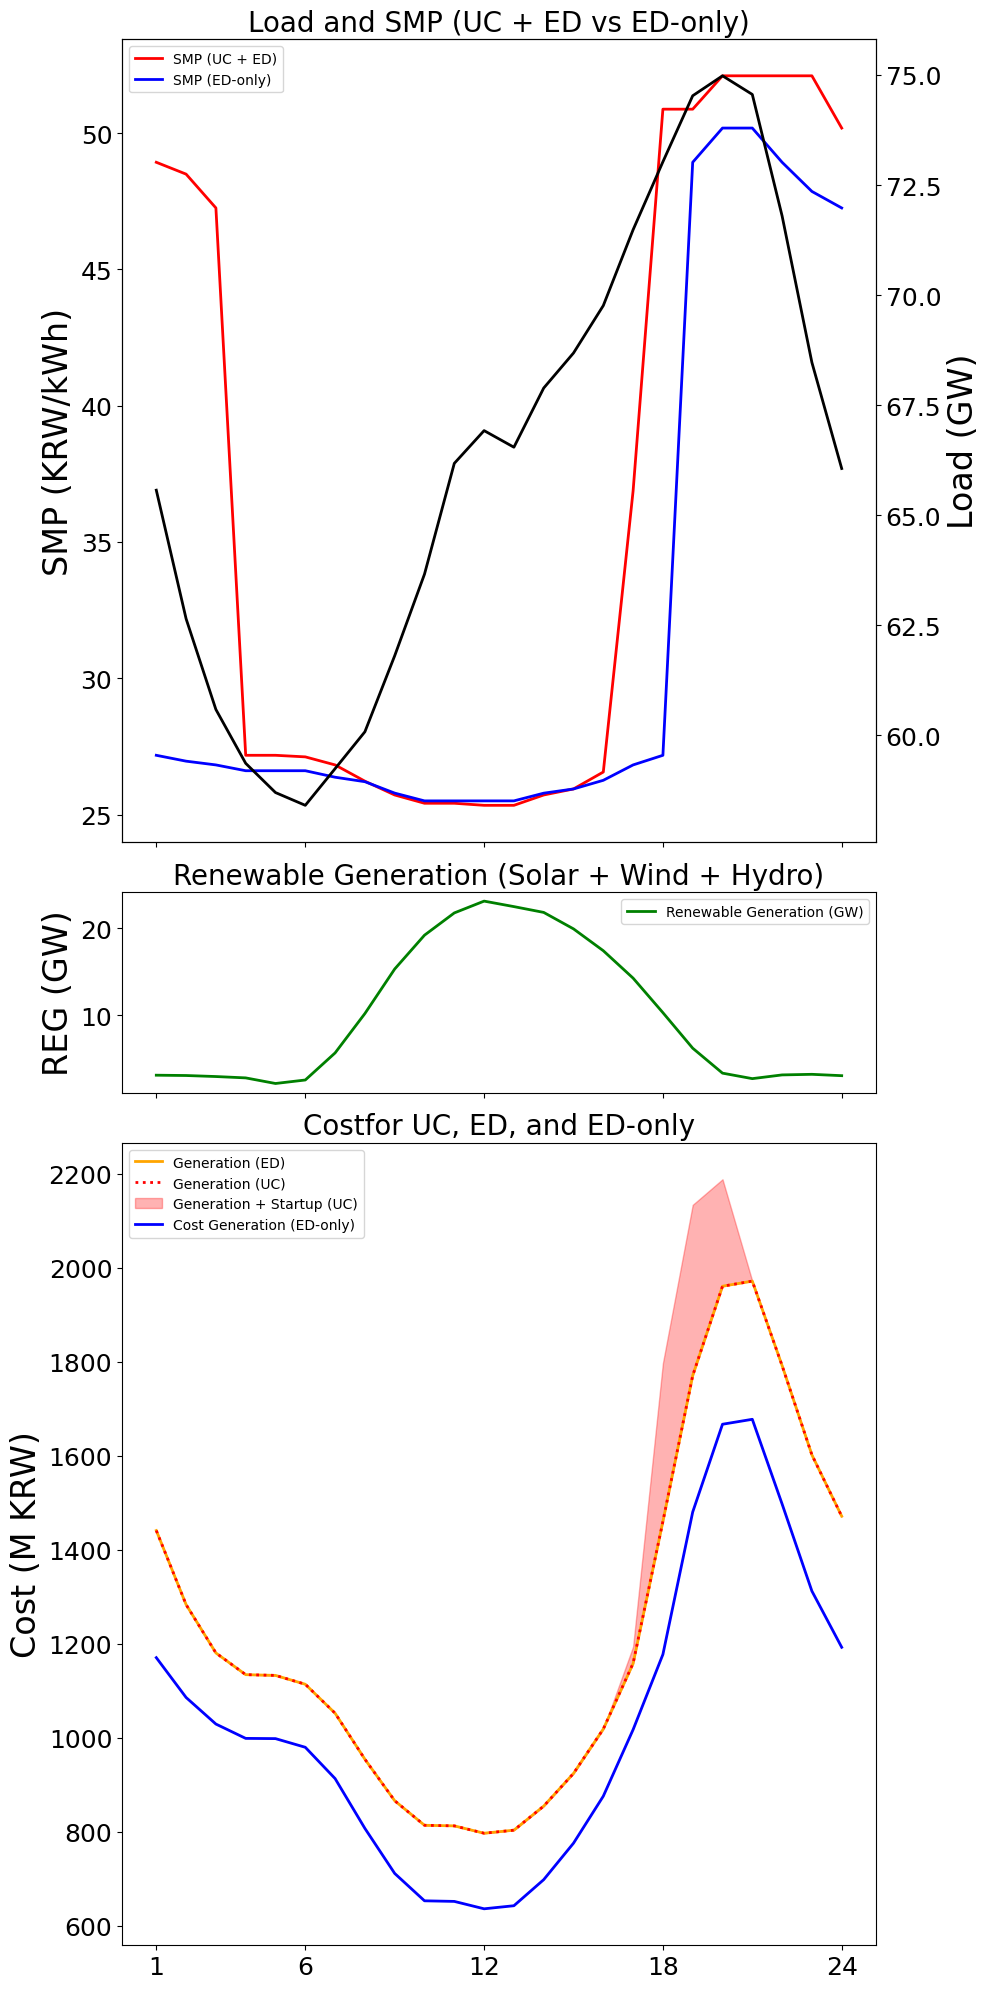

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming that output_ed, output_ed_onlyq1, and output_uc are already defined and populated with data
# And assuming `load_plot`, `solar_p_max`, `wind_p`, `hydro_p` are already available from your inputs

# Extract data from output_ed and output_ed_onlyq1
# For load_plot, you should already have this data (e.g., from the 'load_plot' attribute in your input data)
load_plot = np.sum(load, axis=1)  # Total load_plot over all buses for each time period
smp_uc_ed = output_ed.marginal_smp  # SMP from UC + ED
smp_ed_only = output_ed_onlyq1.marginal_smp  # SMP from ED-only
cost_gen_uc = output_uc.cost_generation  # Cost generation from UC (KRW)
cost_gen_ed = output_ed.cost_generation  # Cost generation from ED (KRW)
cost_gen_ed_only = output_ed_onlyq1.cost_generation  # Cost generation from ED-only (KRW)

# Renewable generation (solar + wind + hydro)
reg = solar_p_max + wind_p + hydro_p  # Renewable generation in MW
reg_gw = reg / 1000  # Convert to GW

# Create subplots (3 vertically stacked with ratios 1:0.5:1)
fig, ax = plt.subplots(3, 1, figsize=(10, 20), sharex=True, height_ratios=[1, 0.25, 1])

# Plot 1: load_plot vs SMP
ax[0].plot(np.arange(1, num_periods + 1), smp_uc_ed / 1000, label="SMP (UC + ED)", color="red", linewidth=2)
ax[0].plot(np.arange(1, num_periods + 1), smp_ed_only / 1000, label="SMP (ED-only)", color="blue", linewidth=2)

# Create a second y-axis for load_plot
ax2 = ax[0].twinx()
ax2.plot(np.arange(1, num_periods + 1), load_plot / 1e3, label="load_plot", color="black", linewidth=2)

# Labels for the first plot
ax[0].set_ylabel("SMP (KRW/kWh)", fontsize=24)
ax[0].set_title("Load and SMP (UC + ED vs ED-only)", fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].legend(loc="upper left")
ax2.set_ylabel("Load (GW)", fontsize=24)  # load_plot on the right axis
ax2.tick_params(axis='both', which='major', labelsize=18)

# Plot 2: Renewable Generation (Reg) in GW
ax[1].plot(np.arange(1, num_periods + 1), reg_gw, label="Renewable Generation (GW)", color="green", linewidth=2)

# Labels for the second plot
ax[1].set_ylabel("REG (GW)", fontsize=24)
ax[1].set_title("Renewable Generation (Solar + Wind + Hydro)", fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].legend()

# Plot 3: Cost Generation for UC, ED, and ED-only
ax[2].plot(np.arange(1, num_periods + 1), cost_gen_ed / 1e6, label="Generation (ED)", color="orange", linewidth=2)
ax[2].plot(np.arange(1, num_periods + 1), cost_gen_uc / 1e6, label="Generation (UC)", color="red", linestyle=":", linewidth=2)
ax[2].fill_between(
    np.arange(1, num_periods + 1), 
    cost_gen_uc / 1e6,
    (output_uc.cost_generation + output_uc.cost_startup) / 1e6, label="Generation + Startup (UC)", color="red", alpha =0.3)

ax[2].plot(np.arange(1, num_periods + 1), cost_gen_ed_only / 1e6, label="Cost Generation (ED-only)", color="blue", linewidth=2)

# Labels for the third plot
ax[2].set_ylabel("Cost (M KRW)", fontsize=24)
ax[2].set_title("Costfor UC, ED, and ED-only", fontsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=18)
ax[2].legend()

# Set x-axis ticks to 1, 6, 12, 18, 24
ax[2].set_xticks([1, 6, 12, 18, 24])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


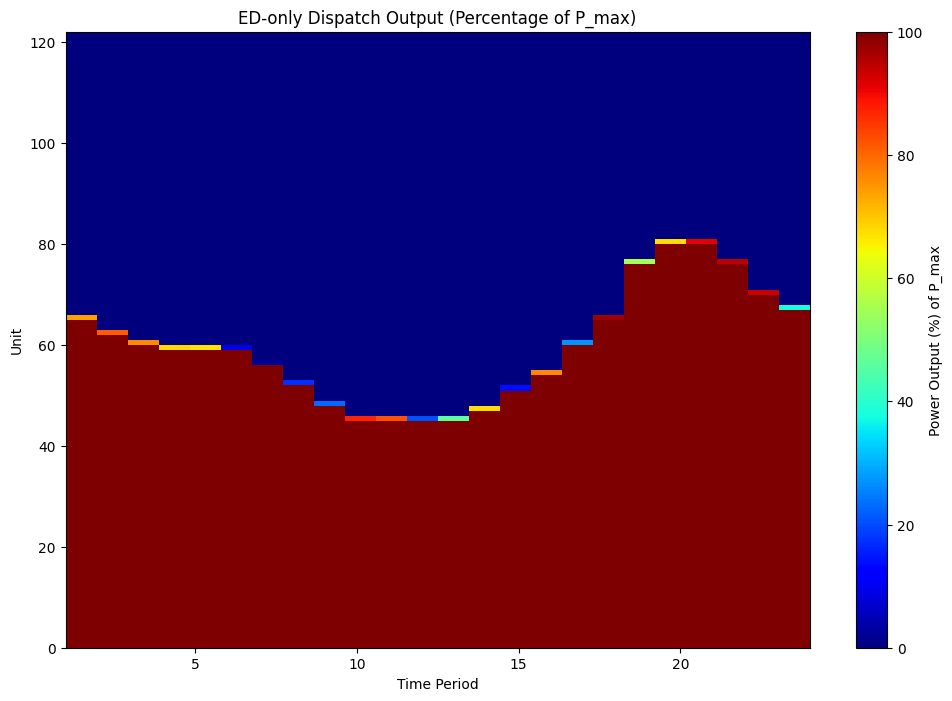

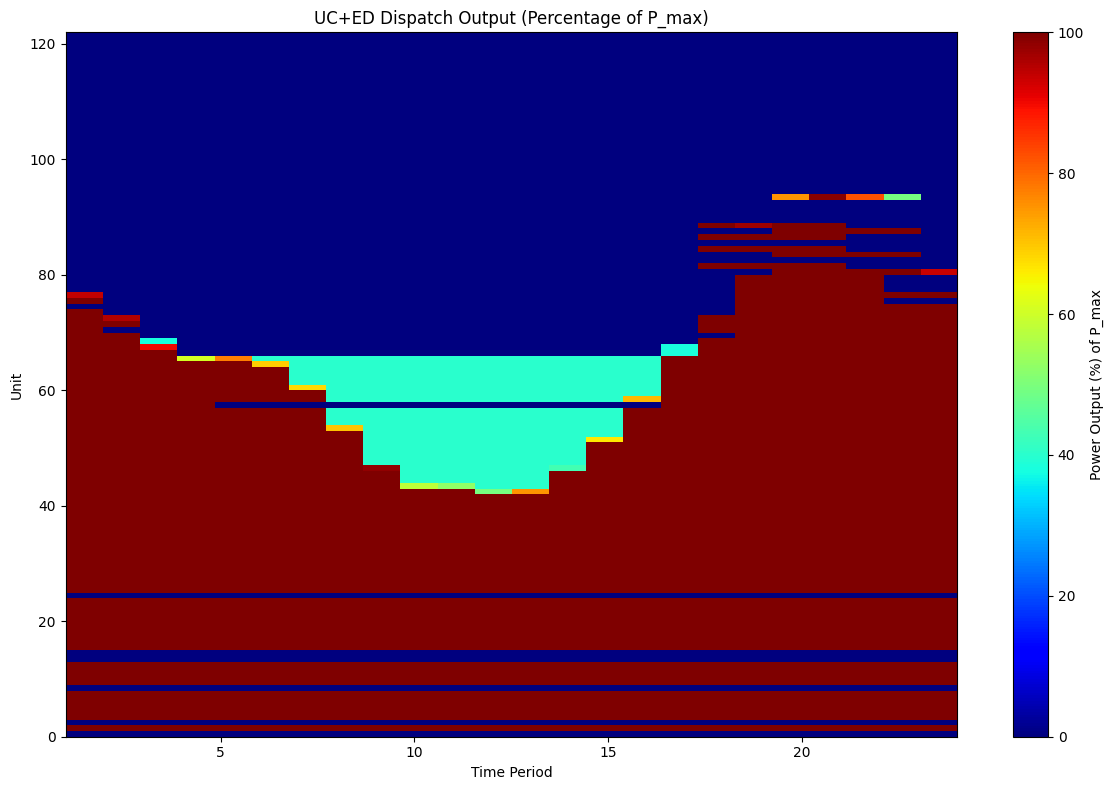

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming we already have output_ed_onlyq1 and output_uc from the previous code execution

# Time periods (1 to 24)
time_periods = np.arange(1, 25)

# Units (sorted by cost_lin)
sorted_units_idx = np.argsort(cost_lin)  # Sorting units by cost_lin

# ED-only case
fig1, ax1 = plt.subplots(figsize=(12, 8))

# Calculate the percentage of p_max for each unit and time period (power_output / p_max)
ed_only_power_pct = np.array([output_ed_onlyq1.p[i, :] / p_max[i] * 100 for i in sorted_units_idx])

# Create the heatmap using the jet colormap
cax1 = ax1.imshow(ed_only_power_pct, aspect='auto', cmap='jet', origin='lower', extent=[1, 24, 0, num_units])

ax1.set_xlabel('Time Period')
ax1.set_ylabel('Unit')
ax1.set_title('ED-only Dispatch Output (Percentage of P_max)')
fig1.colorbar(cax1, ax=ax1, label='Power Output (%) of P_max')

# UC+ED case
fig2, ax2 = plt.subplots(figsize=(12, 8))

# Calculate the percentage of p_max for each unit and time period (power_output / p_max)
uc_ed_power_pct = np.array([output_ed.p[i, :] / p_max[i] * 100 for i in sorted_units_idx])

# Create the heatmap using the jet colormap
cax2 = ax2.imshow(uc_ed_power_pct, aspect='auto', cmap='jet', origin='lower', extent=[1, 24, 0, num_units])

ax2.set_xlabel('Time Period')
ax2.set_ylabel('Unit')
ax2.set_title('UC+ED Dispatch Output (Percentage of P_max)')
fig2.colorbar(cax2, ax=ax2, label='Power Output (%) of P_max')

plt.tight_layout()
plt.show()


In [ ]:
asdf

---
---
---

QUESTION 2
NORMAL UC

In [11]:
input_uc = Input_uc(
    # meta
    num_units=num_units,
    num_periods=num_periods,
    num_buses=num_buses,
    voll=3500*1300,
    let_blackout=False,
    curtail_penalty=0,
    let_curtail=False,
    exact_reserve=False,
    # renewable
    solar_p_max=solar_p_max,
    solar_p_min=solar_p_min,
    wind_p=wind_p,
    hydro_p=hydro_p,
    # system
    load=load,
    system_reserve_up=system_reserve_up,
    system_reserve_down=system_reserve_down,
    # operational constraint
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    # generation cost function
    cost_quad=cost_quad,
    cost_lin=cost_lin,
    cost_const=cost_const,
    # previous horizon
    p_prev=p_prev,
    u_prev=u_prev,
    # startup cost function
    cost_startup_step=cost_startup_step,
    # mustoff
    mustoff=mustoff,
)

In [ ]:
output_uc = Output_uc()
solve_uc(input_uc=input_uc, output_uc=output_uc)

In [ ]:
print(output_uc.cost_generation.sum() - output_uc.total_cost_generation)
print(output_uc.cost_startup.sum() - output_uc.total_cost_startup)
print(output_uc.cost_voll.sum() - output_uc.total_cost_voll)
print(output_uc.cost_curtail_penalty.sum() - output_uc.total_cost_curtail_penalty)


-2.288818359375e-05
0.0
0.0
0.0


SNAPSHOT UC

In [ ]:
output_uc_snapshot = Output_uc_snapshot(num_periods=num_periods, num_units=num_units)

for time_period in range(num_periods):
    solve_uc_snapshot(time_period=time_period, input_uc=input_uc, output_uc=output_uc_snapshot)
output_uc_snapshot.compute_auxiliary_results()

---
---
---

In [ ]:
output_ed = Output_ed(num_periods=num_periods, num_units=num_units, num_buses=num_buses)

for time_period in range(num_periods):
    input_ed = Input_ed(
        # meta
        time_period=time_period,
        num_units=num_units,
        num_buses=num_buses,
        voll=3500*1300,
        let_blackout=False,
        curtail_penalty=0,
        let_curtail=False,
        exact_reserve=False,
        # renewable
        solar_p_max=solar_p_max,
        solar_p_min=solar_p_min,
        # uc
        input_uc=input_uc,
        output_uc=output_uc,
    )

    solve_ed(input_ed=input_ed, output_ed=output_ed)

output_ed.compute_auxiliary_results()
output_uc.compute_auxiliary_results(output_ed=output_ed)

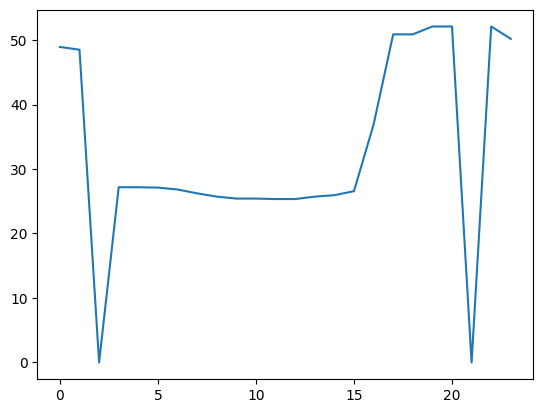

In [ ]:
import matplotlib.pyplot as plt
plt.plot(output_ed.marginal_smp / 1000)